# _Portulaca amilis_ genome analyses and plotting
This notebook contains a growing set of analyses and plots from the annotation of the _Portulaca amilis_ genome. Currently this includes

1. Plotting _P. amilis_ contig and BUSCO statistics relative to currently available plant genomes
2. Production of a [repeat landscape plots](http://repeatmasker.org/genomicDatasets/RMGenomicDatasets.html) from `RepeatMasker` output files
3. References

### To do
- Get references together

In [17]:
# Core
import re, os, glob, sys
import pandas as pd
from itertools import cycle, islice
import numpy as np
# Plotting
%matplotlib inline
from jupyterthemes import jtplot
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(context="notebook", theme='oceans16', grid=False)
%config InlineBackend.figure_format ='retina'
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns

## 1. The _P. amilis_ genome relative to currently available plant geneome
Using supplementary data from [Zhao and Schranz (2019)](https://www.pnas.org/content/116/6/2165), which contains statistics on genome size, N50, and BUSCO completeness, I'll compare the _P. amilis_ genome assembly and annotations to ~100 angiosperm genomes.

In [18]:
angiogenomes = pd.read_csv("../Data/Zhao_Schranz_2019/Angiosperm.csv")
angiogenomes.rename(columns={"#Gene_models":"Gene models"}, inplace=True)
angiogenomes.head()

,No.,Lineage,Family,Species,Order,Family.1,Common Name,Abbreviation,Assembly_Version,Source,Gene models,N50 (Mb),Size (Mb),Scaffolds,BUSCO,Resource,Average_Syntenic_Percentage
0,35,Angiosperms,Rosids,Arabidopsis thaliana,Brassicales,Brassicaceae,Thale cress,ath,TAIR10,Phytozome,27416,23.5,135,7,"C:99.3%[S:98.3%,D:1.0%],F:0.3%,M:0.4%,n:1440",https://phytozome.jgi.doe.gov/pz/portal.html,29.76
1,36,Angiosperms,Rosids,Camelina sativa,Brassicales,Brassicaceae,False flax,Csat,Cs,NCBI,82569,30.1,641,37212,"C:99.2%[S:3.1%,D:96.1%],F:0.4%,M:0.4%,n:1440",https://www.ncbi.nlm.nih.gov/genome/?term=Came...,28.37
2,13,Angiosperms,Rosids,Prunus persica,Rosales,Rosaceae,Peach,ppe,v2.1,Phytozome,26873,27.4,227,191,"C:98.8%[S:97.5%,D:1.3%],F:0.8%,M:0.4%,n:1440",https://phytozome.jgi.doe.gov/pz/portal.html,34.60
3,85,Angiosperms,Monocots,Brachypodium distachyon,Poales,Poaceae,Stiff Brome,bdi,v3.1,Phytozome,34310,22.0,272,27,"C:98.6%[S:97.4%,D:1.2%],F:0.8%,M:0.6%,n:1440",https://phytozome.jgi.doe.gov/pz/portal.html,12.49
4,41,Angiosperms,Rosids,Thellungiella halophila,Brassicales,Brassicaceae,Salt cress,thh,173,Brassica Database,29284,8.0,241,639,"C:98.5%[S:86.3%,D:12.2%],F:0.7%,M:0.8%,n:1440",http://brassicadb.org/brad/,27.90


I'll use some regex commands to extract the numbers out of the BUSCO formatted column `BUSCO`, which currently look like `C:99.3%[S:98.3%,D:1.0%],F:0.3%,M:0.4%,n:1440`.

In [19]:
complete, single, duplicated, fragmented, missing = [], [], [], [], []
for taxon in angiogenomes["BUSCO"]:
    complete.append(float(re.findall(pattern="C:([0-9\.]+)", string=taxon)[0]))
    single.append(float(re.findall(pattern="S:([0-9\.]+)", string=taxon)[0]))
    duplicated.append(float(re.findall(pattern="D:([0-9\.]+)", string=taxon)[0]))
    fragmented.append(float(re.findall(pattern="F:([0-9\.]+)", string=taxon)[0]))
    missing.append(float(re.findall(pattern="M:([0-9\.]+)", string=taxon)[0]))
angiogenomes["Complete"] = complete
angiogenomes["Single"] = single
angiogenomes["Duplicated"] = duplicated
angiogenomes["Fragmented"] = fragmented
angiogenomes["Missing"] = missing

Now I'll add the data I have for _Portulaca amilis_.

In [20]:
angiogenomes = angiogenomes.append({"Lineage":"Angiosperms", "Family":"Super-Asterids", "Species":"Portulaca amilis",
                    "Order":"Caryophyllales", "Family.1":"Portulacaceae", "N50 (Mb)":42.597560,
                    "Size (Mb)":403.885173, "Scaffolds":9, "Complete":89.7, "Single":85.3, "Duplicated":4.4,
                    "Fragmented":2.0, "Missing":8.33, "Gene models":46056}, ignore_index=True)

And we can look at the correlation among our numerical features.

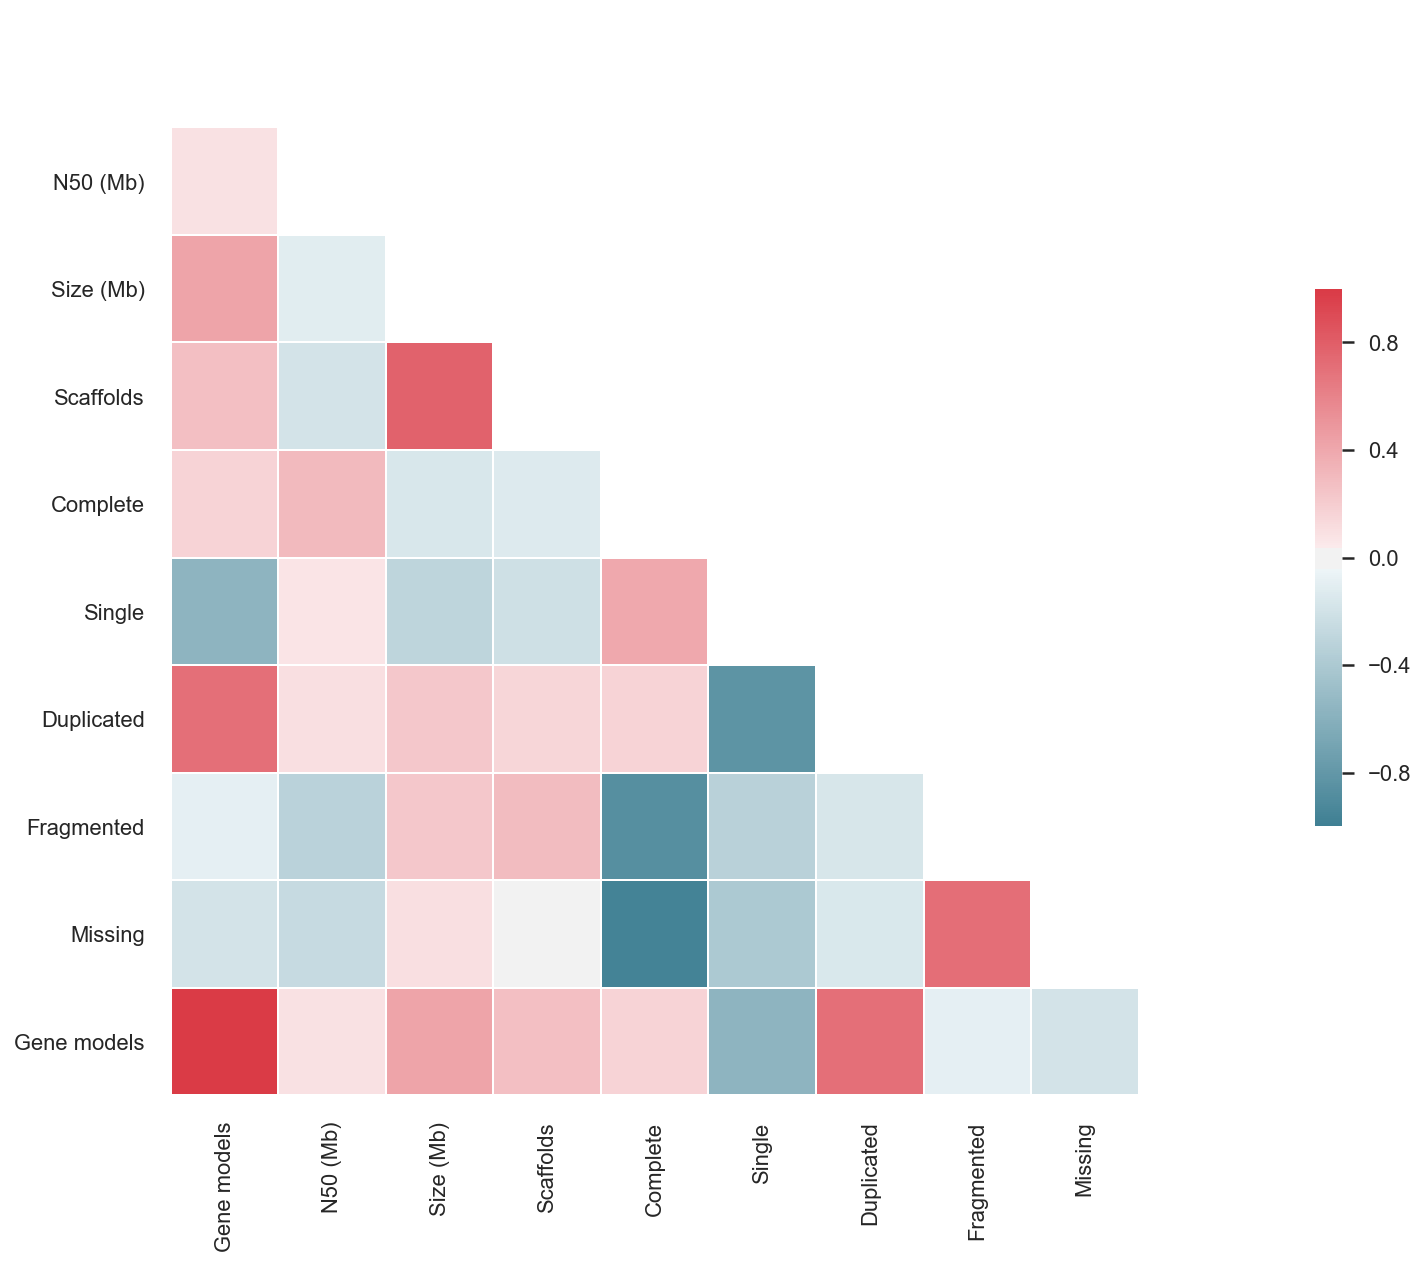

In [21]:
sns.set(style="white")

# Compute the correlation matrix
quantitative = ['Gene models', 'N50 (Mb)', 'Size (Mb)', 'Scaffolds', 'Complete', 'Single', 'Duplicated', 'Fragmented', 'Missing', 'Gene models']
corr = angiogenomes[quantitative].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

ax.set_xticklabels(quantitative[:-1])
ax.set_yticks([i+0.5 for i in range(1,len(quantitative))])
ax.set_yticklabels(quantitative[1:])

plt.tight_layout()
# plt.savefig("../Figures/Angiosperm_genomes.corr.pdf", dpi = 100, transparent=True)

Another way to view these data is to overlay the genome size on top of the BUSCO data. I arbitrarily chose genome size here, and any of the other quantitative measures (N50, number of gene models, etc) could be used instead. To make plotting easier I'll make a genome size-sorted copy of `angiogenomes`.

In [22]:
bysize = angiogenomes.sort_values(by="Size (Mb)").reset_index(drop=True).copy()
byN50 = angiogenomes.sort_values(by="N50 (Mb)").reset_index(drop=True).copy()

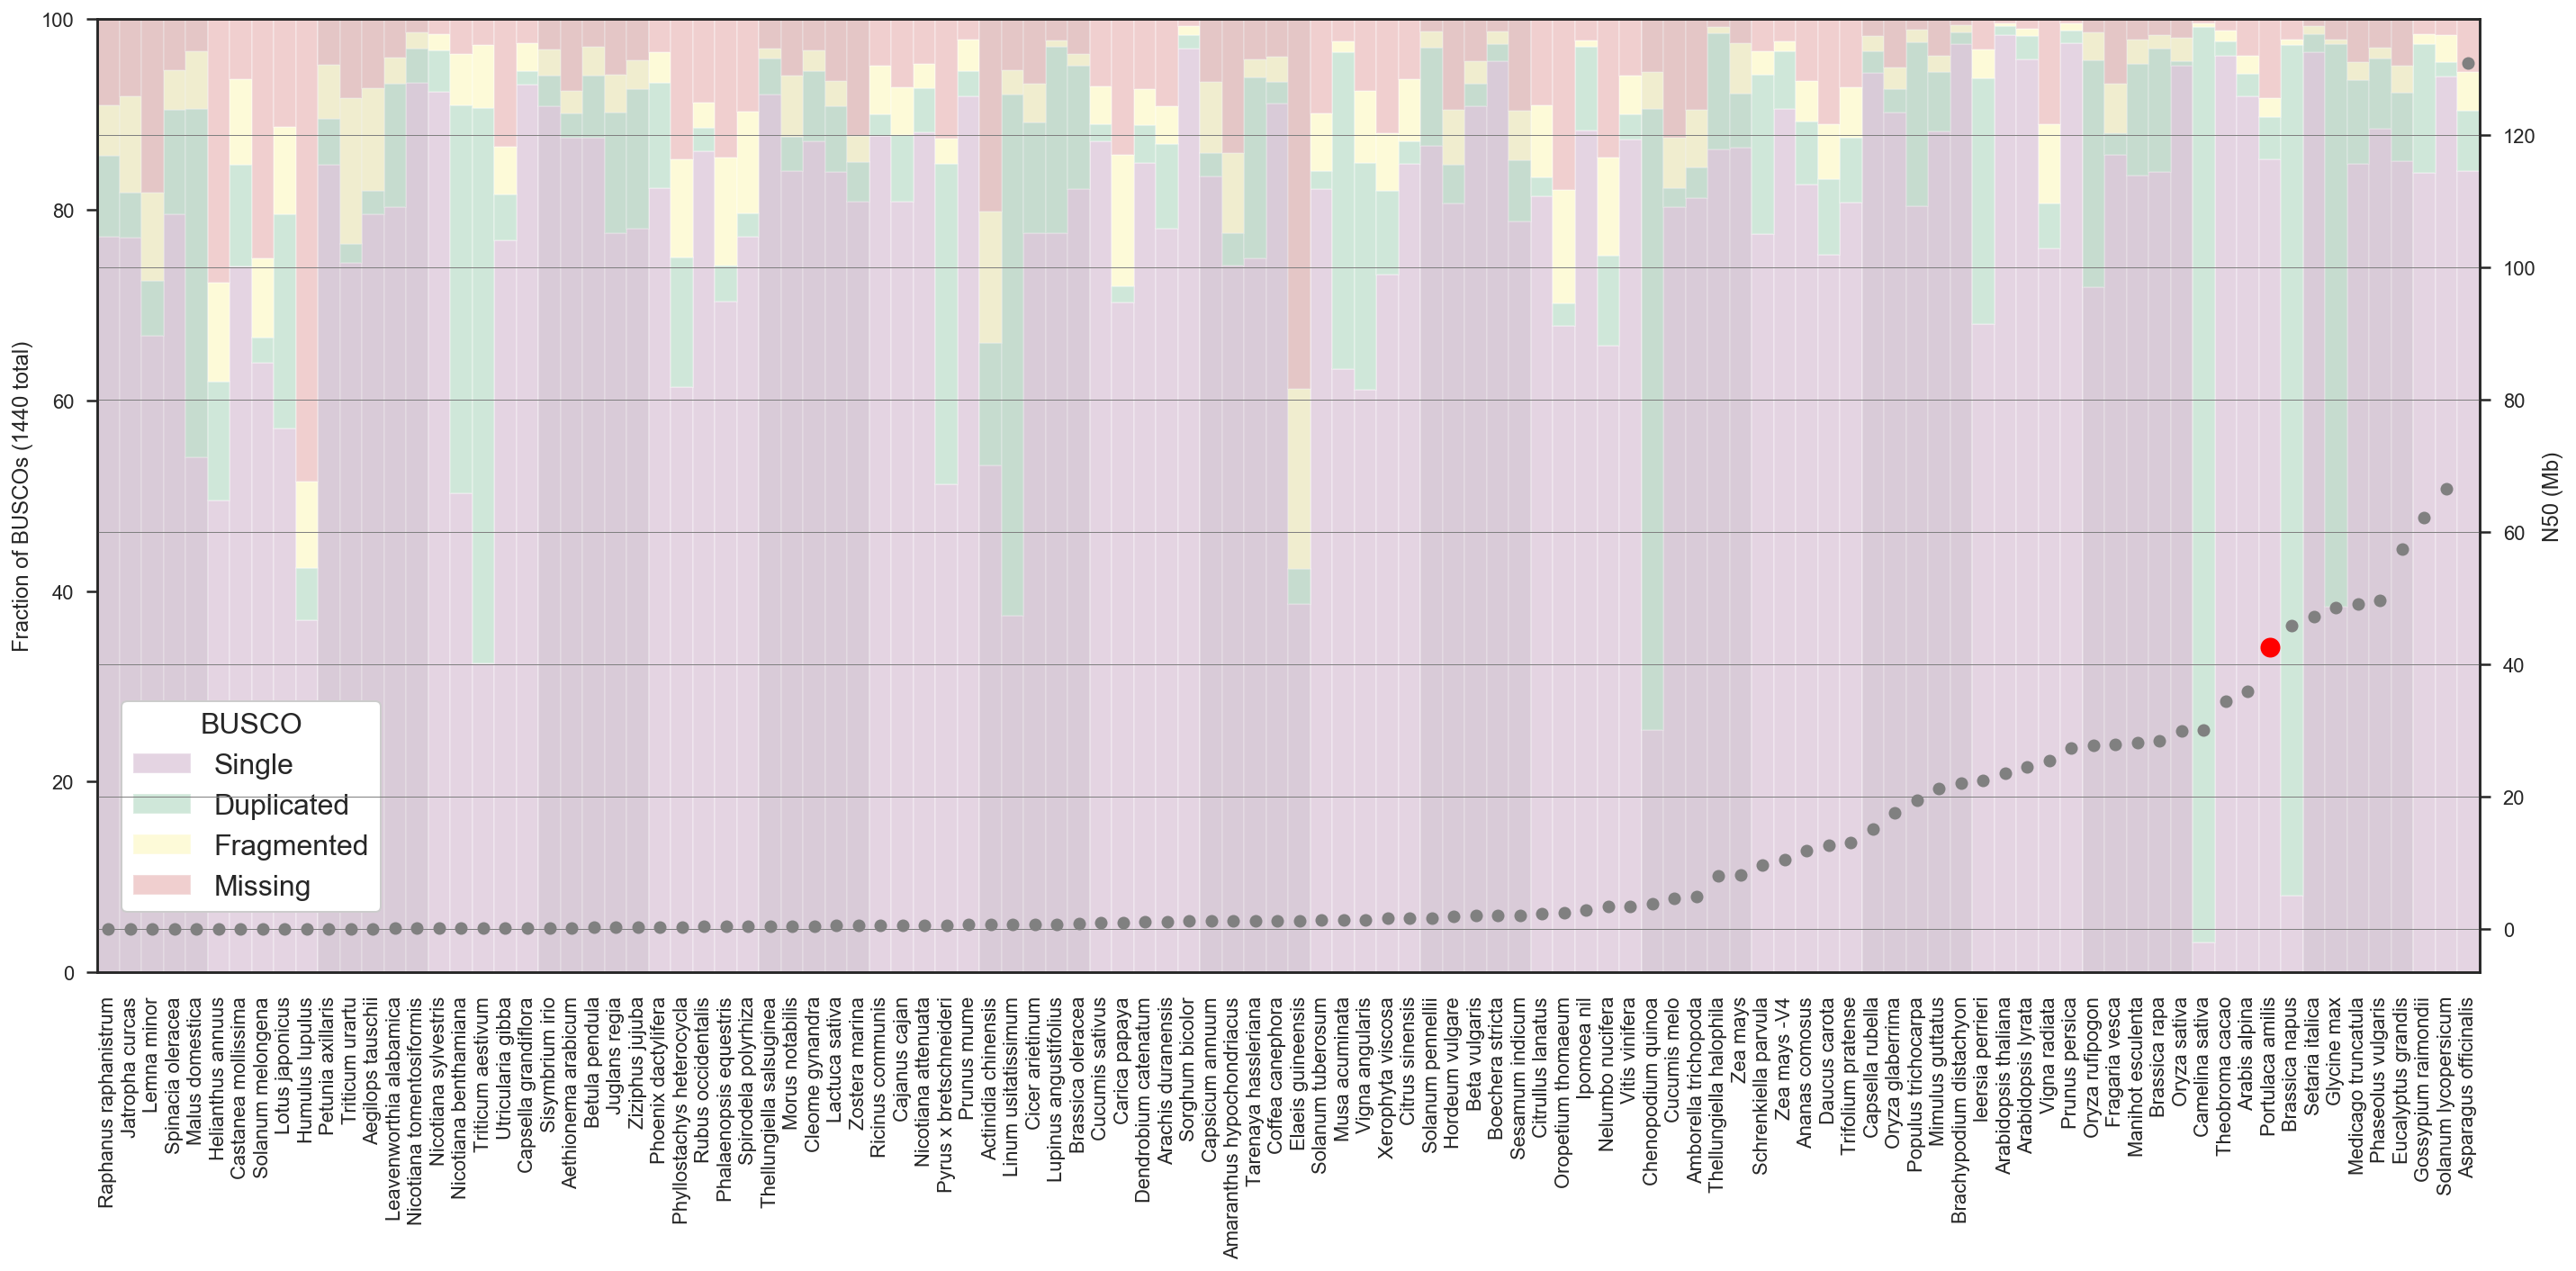

In [23]:
fig, ax = plt.subplots(figsize=(20,10), sharey=True)

buscolors = list(islice(cycle(['xkcd:purplish', 'xkcd:greenish', 'xkcd:yellowish', 'xkcd:reddish']), None, len(byN50)))

# byN50 = angiogenomes.sort_values(by="Size (Mb)").reset_index(drop=True)
byN50[["Single", "Duplicated", "Fragmented", "Missing"]].plot.bar(stacked=True, ax = ax, 
    align="center", width=1, color=buscolors, alpha=0.25)

for i in range(0, 110, 10):
    ax.axvspan(i-0.5, i+4.5, facecolor='grey', alpha=0.1)
    
ax.set_axisbelow(True)
ax.set_ylim([0,100])
ax.set_ylabel("Fraction of BUSCOs (1440 total)")
    
ax2 = ax.twinx()
[line.set_zorder(3) for line in ax2.lines]
ax2.scatter(y=byN50["N50 (Mb)"], x=range(len(angiogenomes)), color="grey")
ax2.scatter(y=byN50[byN50["Species"]=="Portulaca amilis"]["N50 (Mb)"],
            x=byN50[byN50["Species"]=="Portulaca amilis"].index[0], c="red", s=100)

ax2.set_axisbelow(True)
ax2.grid(axis= "y", which='major', linestyle='-', linewidth='0.5', color='grey', zorder=102)
ax2.grid(axis= "y", which='minor', linestyle=':', linewidth='0.5', color='grey', zorder=102)
ax2.set_xticks(range(len(angiogenomes)))
ax2.set_xticklabels(angiogenomes.sort_values(by="N50 (Mb)")["Species"], size=8)
ax2.set_xlim([-0.5, len(angiogenomes)-0.5])
# ax2.set_xlim([10, byN50["N50 (Mb)"].max()*1.1])
# ax2.semilogx()
ax2.set_ylabel("N50 (Mb)")

legend = ax.legend(fancybox=True, title="BUSCO", loc='best', bbox_to_anchor=(0.125, 0.3), 
                   fontsize=16, title_fontsize=16)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(1.0)

plt.tight_layout()
# plt.savefig("../Figures/N50.BUSCO.pdf", dpi = 100, transparent=True)
# plt.savefig("../Figures/N50.BUSCO.png", dpi = 100, transparent=True)

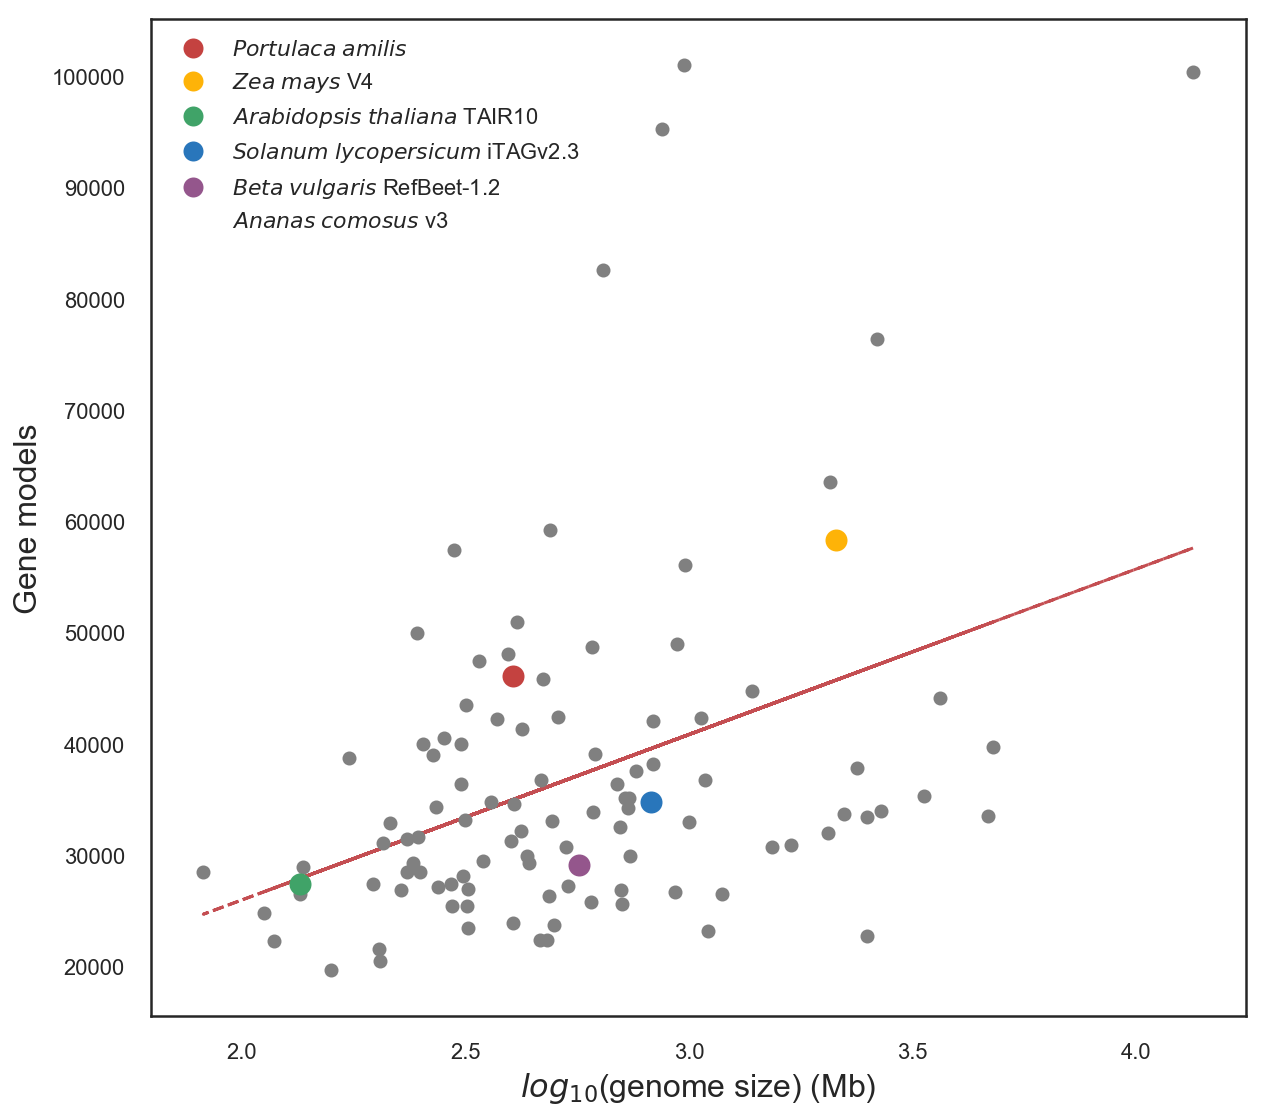

In [24]:
fig, ax = plt.subplots(figsize=(9,8))

ax.scatter(x=np.log10(angiogenomes["Size (Mb)"]), y=angiogenomes["Gene models"], color="grey")

x = np.log10(angiogenomes["Size (Mb)"])
y = angiogenomes["Gene models"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax.plot(x,p(x),"r--", zorder=0)

ax.scatter(x=np.log10(angiogenomes[angiogenomes["Species"]=="Portulaca amilis"]["Size (Mb)"]), 
           y=angiogenomes[angiogenomes["Species"]=="Portulaca amilis"]["Gene models"], c="xkcd:reddish", s=100)
ax.scatter(x=np.log10(angiogenomes[angiogenomes["Species"]=="Zea mays -V4"]["Size (Mb)"]), 
           y=angiogenomes[angiogenomes["Species"]=="Zea mays -V4"]["Gene models"], c="xkcd:amber", s=100)
ax.scatter(x=np.log10(angiogenomes[angiogenomes["Species"]=="Arabidopsis thaliana"]["Size (Mb)"]), 
           y=angiogenomes[angiogenomes["Species"]=="Arabidopsis thaliana"]["Gene models"], c="xkcd:greenish", s=100)
ax.scatter(x=np.log10(angiogenomes[angiogenomes["Species"]=="Solanum lycopersicum"]["Size (Mb)"]), 
           y=angiogenomes[angiogenomes["Species"]=="Solanum lycopersicum"]["Gene models"], c="xkcd:bluish", s=100)
ax.scatter(x=np.log10(angiogenomes[angiogenomes["Species"]=="Beta vulgaris"]["Size (Mb)"]), 
           y=angiogenomes[angiogenomes["Species"]=="Beta vulgaris"]["Gene models"], c="xkcd:purplish", s=100)
ax.scatter(x=np.log10(angiogenomes[angiogenomes["Species"]=="Ananas comosus"]["Size (Mb)"]), 
           y=angiogenomes[angiogenomes["Species"]=="Ananas comosus"]["Gene models"], c="xkcd:white", s=100)

ax.set_xlabel("$log_{10}$(genome size) (Mb)", size=16)
ax.set_ylabel("Gene models", size=16)

portulaca = mlines.Line2D([], [], color='xkcd:reddish', marker='o', linestyle='None', markersize=10, label='$Portulaca$ $amilis$')
zeamays = mlines.Line2D([], [], color='xkcd:amber', marker='o', linestyle='None', markersize=10, label='$Zea$ $mays$ V4')
arabidopsis = mlines.Line2D([], [], color='xkcd:greenish', marker='o', linestyle='None', markersize=10, label='$Arabidopsis$ $thaliana$ TAIR10')
solanum = mlines.Line2D([], [], color='xkcd:bluish', marker='o', linestyle='None', markersize=10, label='$Solanum$ $lycopersicum$ iTAGv2.3')
beta = mlines.Line2D([], [], color='xkcd:purplish', marker='o', linestyle='None', markersize=10, label='$Beta$ $vulgaris$ RefBeet-1.2')
pineapple = mlines.Line2D([], [], color='xkcd:white', marker='o', linestyle='None', markersize=10, label='$Ananas$ $comosus$ v3')

plt.legend(handles=[portulaca, zeamays, arabidopsis, solanum, beta, pineapple], loc="upper left", frameon=False)

plt.tight_layout()
# plt.savefig("../Figures/Gsize.Gene-models.png", dpi=100, transparent=False)

## 2. Repeat Analysis
Here I'll show how to create a repeat landscape plot using the `.Rfam.tab` file created by [`parseRM.pl`](https://github.com/4ureliek/Parsing-RepeatMasker-Outputs) or `calcDivergenceFromAlign.pl`+ `createRepeatLandscape.pl` from the `RepeatMasker` accessory files.

In [25]:
allmask_dir = "../Data/RepeatMasker/"
allmask = pd.read_csv(glob.glob(allmask_dir+"*.Rfam.tab")[0], sep="\t", skiprows=1)
allmask.head()

,Rclass,Rfam,[0;1[,[1;2[,[2;3[,[3;4[,[4;5[,[5;6[,[6;7[,[7;8[,...,[40;41[,[41;42[,[42;43[,[43;44[,[44;45[,[45;46[,[46;47[,[47;48[,[48;49[,[49;50[
0,DNA?,DNA?,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Retro,Retro,9777,33148,64106,102812,233998,353283,545076,760350,...,0,0,0,0,0,0,0,0,0,0
2,Unknown,Unknown,4924,33889,126482,229392,288099,379445,367282,336660,...,0,0,0,0,0,0,0,0,0,0
3,LINE,R1-LOA,0,229,0,1835,3553,3705,1664,2096,...,0,0,0,0,0,0,0,0,0,0
4,SINE,tRNA-RTE,903,3362,7523,7529,12598,15561,18703,25660,...,0,0,0,0,0,0,0,0,0,0


In its current format, this dataframe has the repeat classes and families in the first and second columns, followed by columns with [Kimura two-parameter distance](https://en.wikipedia.org/wiki/Models_of_DNA_evolution#K80_model_(Kimura_1980)) bins of width 1. When we processed our repeats, a consensus sequence was generated for each repeat family. Then, the Kimura distance between each repeat of that family and the consensus was measured, and all of the basepairs of that repeat were binned. 

To get the dataframe into a form ammenable to repeat landscape plots (i.e. stack barcharts) we'll convert the units of basepairs into fraction of genome, transpose the dataframe, and use the repeat families or classes as columns. You'll also notice some classes and families ending in `?`, suggesting we aren't completely sure of the class or family. There are three ways we could handle this: leave them as is, lump them all into the `Unknown` category, or lump them all into the categories they match most closely with. Together, these ambiguous repeats account for ~0.018% of all repeats so these strategies produce almost indistinguishable results. So, for simplicity I'm going to call them all `Unknown`, but this can be changed with the `ambiguities` parameter below.

In [26]:
ambiguities = "Unknown" # Takes either "Unknown" or "Lump"

# Rename columns
new_cols = []
for col in allmask.columns:
    if col.startswith("["): new_cols.append("-".join(re.findall("\d+", col)))
    else: new_cols.append(col)
allmask.columns = new_cols

if ambiguities == "Unknown":
    allmask.loc[allmask["Rclass"].str.contains("\?"), "Rclass"] = "Unknown"
    allmask.loc[allmask["Rfam"].str.contains("\?"), "Rfam"] = "Unknown"
elif ambiguities == "Lump":
    allmask["Rclass"] = allmask["Rclass"].replace("[^0-9a-zA-Z]+", "", regex=True)
    allmask["Rfam"] = allmask["Rfam"].replace("[^0-9a-zA-Z]+", "", regex=True)

# Convert to percentages
genome_size = 403885173
allmask[allmask.select_dtypes(include=['number']).columns]# /= (genome_size*100)

# Get Rfam matrix
rfam = allmask.drop(labels=["Rclass"], axis=1).copy()
rfam = rfam.groupby(by="Rfam").sum().T
rfam = rfam / genome_size * 100

# Get Rclass matrix
rclass = allmask.drop(labels=["Rfam"], axis=1).copy()
rclass = rclass.groupby(by="Rclass").sum().T
rclass = rclass / genome_size * 100

rclass.head()

Rclass,DNA,LINE,LTR,RC,Retro,Retroposon,SINE,Unknown,nonLTR
0-1,0.014615,0.030580,0.008990,0.000097,0.002421,0.0,0.001281,0.001862,0.000051
1-2,0.070097,0.019431,0.046145,0.000401,0.008207,0.0,0.009938,0.009135,0.000224
2-3,0.150482,0.029969,0.177990,0.001118,0.015872,0.0,0.039458,0.032131,0.000602
3-4,0.257392,0.065082,0.422694,0.002563,0.025456,0.0,0.068673,0.057401,0.002715
4-5,0.350110,0.106198,0.522778,0.003947,0.057937,0.0,0.064201,0.072003,0.005694


Now that the data is reformatted it's ready to be plotted. It can be difficult to visualize the dozens of unique repeat familes using standard color maps because they're often sequencial. I wrote a short random color generator below to facilitate the production of repeat landscapes.

In [27]:
def random_XKCD_colors(N, palette=None, replace=False, seed=None, plot=True):
    '''Creates a list of random colors from the XKCD color survey.
    
    Parameters
    ----------
    N : <int> number of colors to sample
    palette : <str> or <NoneType> Sub-palette to sample from. Options are "light", "dark", "pale", and "ish"
                (Default=None)
    replace : <bool> Sample with/without replacement (Default=False)
    seed : <int> Random seed for numpy (Default=None)
    plot : <bool> Generate a plot of the resulting color palette
    '''
    from matplotlib import colors as mcolors
    
    np.random.seed(seed=seed)
    colors = list(mcolors.XKCD_COLORS.keys())
    if palette=="light": 
        colors = [color for color in colors if "light" in color]
    if palette=="dark": 
        colors = [color for color in colors if "dark" in color]
    if palette=="pale": 
        colors = [color for color in colors if "pale" in color]
    if palette=="ish": 
        colors = [color for color in colors if "ish" in color]
    unique_colors = len(colors)
    
    if N>unique_colors:
        print("You asked for more unique colors ({}) than the {} palette contains ({}).\nTry using a different palette or set palette to None to sample from all {} colors.".format(N, palette, unique_colors, len(mcolors.XKCD_COLORS.keys())))
        return 
    
    my_colors = np.random.choice(colors, replace=replace, size=N)
    
    if plot: 
        ncols = max([1, np.round(N, decimals=-1)/10])
        nrows = N // ncols
        fig, ax = plt.subplots(figsize=(6, 6))
        
        X, Y = fig.get_dpi() * fig.get_size_inches()
        h = Y / (nrows + 1)
        w = X / ncols

        for i, name in enumerate(my_colors):
            row = i % nrows
            col = i // nrows
            y = Y - (row * h) - h
            xi_line = w * (col + 0.05)
            xf_line = w * (col + 0.25)
            ax.hlines(y + h * 0.1, xi_line, xf_line, color=name, linewidth=(h)*0.9)

        ax.set_xlim(0, X)
        ax.set_ylim(0, Y)
        ax.set_axis_off()
        plt.tight_layout()
    
    return my_colors

Also, the combination of axes mixed with `tight_layout` in the next plot often give a warning, so I turned off warnings for this notebook.

In [28]:
import warnings
warnings.filterwarnings('ignore')

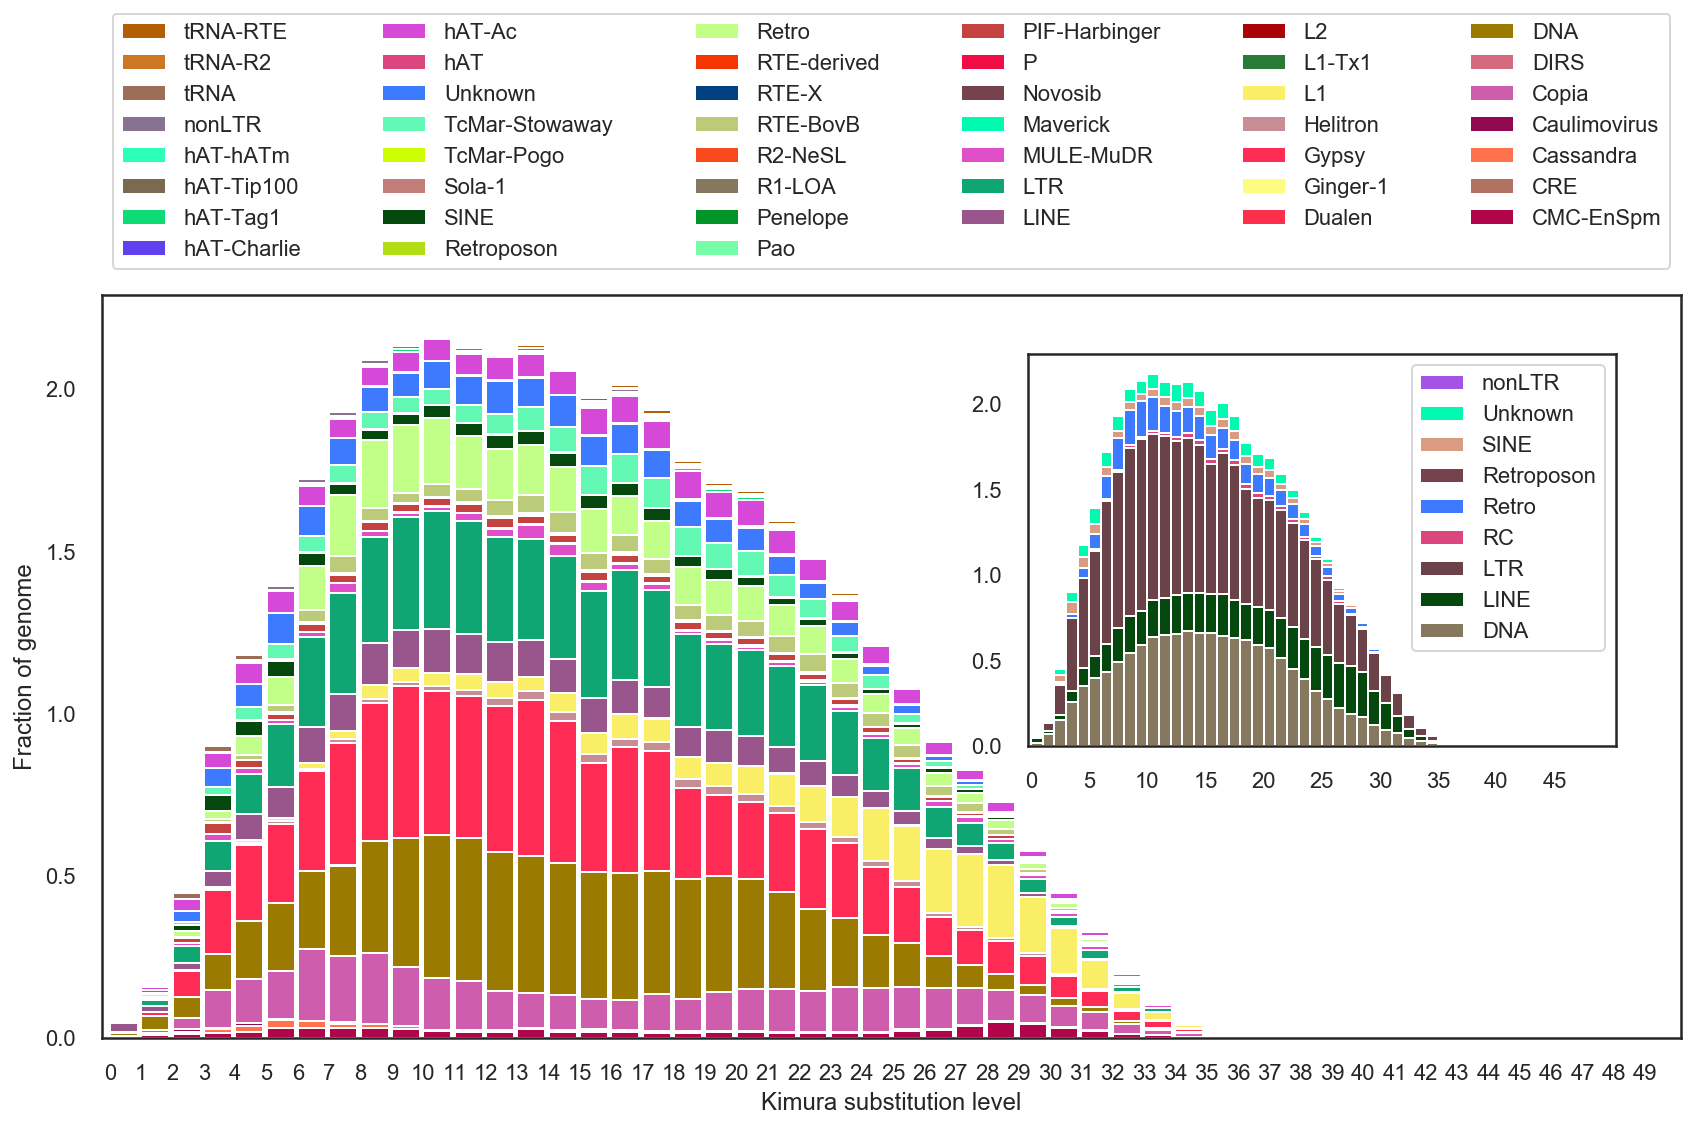

In [29]:
fig, ax = plt.subplots(figsize=(12,8))

# Create color map for rfam
N_colors = len(rfam.columns)
N_cycles = len(rfam)
my_colors = random_XKCD_colors(N_colors, palette="ish", replace=False, seed=6, plot=False)
color_cycle = list(islice(cycle(my_colors), None, N_cycles))
# Make stacked barplot for rfam
rfam.plot.bar(stacked=True, ax = ax, align="edge", width=0.9, color=my_colors, )
# Main legend properties
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc="lower left", ncol=6, fancybox=True, bbox_to_anchor=(0,1.02,1,0.2), mode="expand")
# Main axes formatting
ax.set_xticklabels(range(51))
ax.set_ylabel("Fraction of genome")
ax.set_xlabel("Kimura substitution level")
plt.xticks(rotation=0)

## Rclass inset
left, bottom, width, height = [0.6, 0.34, 0.34, 0.34]
ax2 = fig.add_axes([left, bottom, width, height])
# Create color map for rclass
N_colors = len(rclass.columns)
N_cycles = len(rclass)
my_colors = random_XKCD_colors(N_colors, palette="ish", replace=False, seed=8, plot=False)
color_cycle = list(islice(cycle(my_colors), None, N_cycles))
# Make stacked barplot for rclass
rclass.plot.bar(stacked=True, ax = ax2, align="edge", width=1, color=my_colors)
# Inset legend properties
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[::-1], labels[::-1], loc="upper right", ncol=1, fancybox=True)
# Inset axes labels
ax2.set_xticks(range(0,49, 5))
ax2.set_xticklabels(range(0,49, 5))
ax2.set_ylabel("")
ax2.set_xlabel("")

plt.xticks(rotation=0)
plt.tight_layout()
# plt.savefig("../Figures/P_amilis.repeatlandscape.pdf", dpi = 100, transparent=True)
# plt.savefig("../Figures/P_amilis.repeatlandscape.png", dpi = 100, transparent=True)

In the plot above the main plot shows the repeat family distribution and the inset shows the repeat class distribution. The top left legend color corresponds to the top color in the stacked bars.

## Ploting genomic features
This section still needs a lot of work.

In [39]:
gff3cols = ["seqid", "source", "type", "start", "end", "score", "strand", "phase", "attributes"]
gff3 = pd.read_csv("/Users/iangilman/Dropbox/P_amilis_genome_project/MAKER_single_core/P_amilis_R1.all.maker.noseq.fixed.gff",
                sep="\t", names=gff3cols, skiprows=[0])
gff3.dropna(inplace=True)
gff3.reset_index(inplace=True, drop=True)

In [109]:
gff3.head()

,seqid,source,type,start,end,score,strand,phase,attributes
0,Scaffold_27,.,contig,1.0,3334.0,.,.,.,ID=Scaffold_27;Name=Scaffold_27
1,Scaffold_27,repeat_gff:repeatmasker,match,12.0,199.0,1173,-,.,ID=Scaffold_27:hit:39:1.3.0.0;Name=342270;Targ...
2,Scaffold_27,repeat_gff:repeatmasker,match_part,12.0,199.0,1173,-,.,ID=Scaffold_27:hsp:39:1.3.0.0;Parent=Scaffold_...
3,Scaffold_27,repeat_gff:repeatmasker,match,374.0,3334.0,8096,+,.,ID=Scaffold_27:hit:40:1.3.0.0;Name=342274;Targ...
4,Scaffold_27,repeat_gff:repeatmasker,match_part,374.0,3334.0,8096,+,.,ID=Scaffold_27:hsp:40:1.3.0.0;Parent=Scaffold_...


In [111]:
scaff2366 = gff3.loc[gff3["seqid"]=="Scaffold_2366"]

In [114]:
len(scaff2366)

364772